# UROP

## DESIRE: Distant Future Prediction in Dynamic Scenes with Interacting Agents

[CVPR Paper](https://arxiv.org/pdf/1704.04394.pdf)

[Supplementary Notes](http://www.robots.ox.ac.uk/~namhoon/doc/DESIRE-supp.pdf)

## TODO:

1) Save and load model

2) Train/test flag
  * Train has output Y_hat and z
  * Test has input z array and output Y_hat
  
3) Gradient, i.e. remove straight line/stop (or have some probability of keeping them)

In [1]:
%matplotlib inline

import csv
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

# Sample Generation Module

## Data

In [2]:
def print_line_sep():
    print('--------------------------------------')

In [3]:
raw_data = []
with open('raw_data/raw_record.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    raw_data = list(csvreader)
print('Raw data extract: ([time, car, x, y, ...])')
print(raw_data[0])
print_line_sep()

filtered_data = [[int(row[0]), int(row[1]), float(row[2]), float(row[3])] for row in raw_data]
print('Filtered data extract: ([time, car, x, y])')
print(filtered_data[0])
print_line_sep()

car_dict = {}
for row in filtered_data:
    time = row[0]
    car = row[1]
    x = row[2]
    y = row[3]
    
    if car in car_dict:
        car_dict[car].append([time, x, y])
    else:
        car_dict[car] = [[time, x, y]]
print('Car dictionary extract: ([time, x, y])')
print(car_dict[172][0])
print_line_sep()

time_dict = {}
for row in filtered_data:
    time = row[0]
    car = row[1]
    x = row[2]
    y = row[3]
    
    if time in time_dict:
        time_dict[time].append([car, x, y])
    else:
        time_dict[time] = [[car, x, y]]
print('Time dictionary extract: ([car, x, y])')
print(time_dict[1][0])

Raw data extract: ([time, car, x, y, ...])
['1', '172', '93.939', '-55.7615', '0', '-3.0066', '5.27149', '4', '10']
--------------------------------------
Filtered data extract: ([time, car, x, y])
[1, 172, 93.939, -55.7615]
--------------------------------------
Car dictionary extract: ([time, x, y])
[1, 93.939, -55.7615]
--------------------------------------
Time dictionary extract: ([car, x, y])
[172, 93.939, -55.7615]


In [4]:
def get_batch(x_seq_len, y_seq_len, batch_size, flag='random', remove_linear=False):
    batch = []
    
    car_dict_keys = list(car_dict.keys())
    
    time_dict_lengths = {time: len(entries) for time, entries in time_dict.items() if len(entries) >= batch_size}
    time_dict_keys = list(time_dict_lengths.keys())
    
    # Fill up batch with batch_size rows of x+y_seq_len columns
    while(len(batch) < batch_size):        
        if flag == 'random':
            car = random.choice(car_dict_keys)
            batch_item = []
            is_first_of_sequence = True

            # Loop through each row of that car until x_seq_len+y_seq_len columns are found
            # TODO: randomise which time sequence taken for each car
            for row in car_dict[car]:
                time = row[0]
                x = row[1]
                y = row[2]

                # If first item of the sequence, just append
                if is_first_of_sequence:
                    batch_item.append([time, x, y])
                    is_first_of_sequence = False

                # Else, check if time diff is 1
                else:
                    prev_time = batch_item[-1][0]

                    # If time diff is not 1, clear batch item, and start from current location as first batch item
                    if time - prev_time != 1:
                        batch_item = []
                        batch_item.append([time, x, y])

                    # Else, just append to batch item
                    else:
                        batch_item.append([time, x, y])
                        
                # If batch item columns are enough, break
                if len(batch_item) == x_seq_len + y_seq_len:
                    # TODO: Do not add if straight line or stop by computing second order derivative and see if 0

                    batch.append(batch_item)
                    break
                    
        elif flag == 'sync':
            start_time = random.choice(time_dict_keys)
                        
            # Check if there are batch_size number of cars that stay 
            # from start_time to start_time+x_seq_len+y_seq_len
            for row in time_dict[start_time]:
                if len(batch) == batch_size:
                    break
                
                car = row[0]
                x = row[1]
                y = row[2]
                batch_item = [[car, x, y]]
                    
                for time in range(start_time + 1, start_time + x_seq_len + y_seq_len):
                    for time_row in time_dict[time]:
                        if time_row[0] == car:
                            x = time_row[1]
                            y = time_row[2]
                            batch_item.append([car, x, y])
                            break
                    
                
                if len(batch_item) == x_seq_len + y_seq_len:
                    # TODO: Do not add if straight line or stop by computing second order derivative and see if 0

                    batch.append(batch_item)
                    
            if len(batch) < batch_size:
                batch = []
                
    # Just keep (x,y)  
    X_position_array = [[[item[1], item[2]] for item in batch_item[:x_seq_len]] for batch_item in batch]
    Y_position_array = [[[item[1], item[2]] for item in batch_item[x_seq_len:]] for batch_item in batch]
    
    X_position_np = np.asarray(X_position_array).transpose(0, 2, 1)
    Y_position_np = np.asarray(Y_position_array).transpose(0, 2, 1)
    
    X_position_tensor = Variable(torch.from_numpy(X_position_np).type(torch.FloatTensor)).cuda()
    Y_position_tensor = Variable(torch.from_numpy(Y_position_np).type(torch.FloatTensor)).cuda()
    
    # Convert position to displacement
    X_displacement_array = []
    Y_displacement_array = []

    for i in range(batch_size):
        x_first = X_position_array[i][0][0]
        y_first = X_position_array[i][0][1]

        X_batch = X_position_array[i]
        X_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in X_batch])

        Y_batch = Y_position_array[i]
        Y_displacement_array.append([[item[0] - x_first, item[1] - y_first] for item in Y_batch])

    X_displacement_np = np.asarray(X_displacement_array).transpose(0, 2, 1)    
    Y_displacement_np = np.asarray(Y_displacement_array).transpose(0, 2, 1)
    
    X_displacement_tensor = Variable(torch.from_numpy(X_displacement_np).type(torch.FloatTensor)).cuda()
    Y_displacement_tensor = Variable(torch.from_numpy(Y_displacement_np).type(torch.FloatTensor)).cuda()
    
    return X_position_tensor, Y_position_tensor, X_displacement_tensor, Y_displacement_tensor

In [5]:
# Test random batch

X_position_test, Y_position_test, X_displacement_test, Y_displacement_test = get_batch(20, 40, 8)

print('X positions:')
print(X_position_test.size())
print(X_position_test[0])

print_line_sep()

print('Y positions:')
print(Y_position_test.size())
print(Y_position_test[0])

print_line_sep()

print('X displacements:')
print(X_displacement_test.size())
print(X_displacement_test[0])

print_line_sep()

print('Y displacements:')
print(Y_displacement_test.size())
print(Y_displacement_test[0])

X positions:
torch.Size([8, 2, 20])
tensor([[ 338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340],
        [-122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890, -122.2890, -122.2890, -122.2890, -122.2890,
         -122.2890, -122.2890]], device='cuda:0')
--------------------------------------
Y positions:
torch.Size([8, 2, 40])
tensor([[ 338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338.7340,  338.7340,
          338.7340,  338.7340,  338.7340,  338.7340,  338

In [6]:
# Test synchronised batch

X_position_test, Y_position_test, X_displacement_test, Y_displacement_test = get_batch(20, 40, 8, flag='sync')

print('X positions:')
print(X_position_test.size())
print(X_position_test[0])

print_line_sep()

print('Y positions:')
print(Y_position_test.size())
print(Y_position_test[0])

print_line_sep()

print('X displacements:')
print(X_displacement_test.size())
print(X_displacement_test[0])

print_line_sep()

print('Y displacements:')
print(Y_displacement_test.size())
print(Y_displacement_test[0])

X positions:
torch.Size([8, 2, 20])
tensor([[ 338.7060,  338.7290,  338.7480,  338.7640,  338.7770,  338.7860,
          338.7910,  338.7960,  338.8010,  338.8050,  338.8080,  338.8110,
          338.8130,  338.8150,  338.8170,  338.8180,  338.8200,  338.8210,
          338.8220,  338.8230],
        [ -48.4060,  -48.0072,  -47.6104,  -47.2157,  -46.8231,  -46.4324,
          -46.0439,  -45.6572,  -45.2726,  -44.8899,  -44.5092,  -44.1304,
          -43.7533,  -43.3781,  -43.0046,  -42.6329,  -42.2627,  -41.8933,
          -41.5181,  -41.1304]], device='cuda:0')
--------------------------------------
Y positions:
torch.Size([8, 2, 40])
tensor([[ 338.8230,  338.8240,  338.8240,  338.8250,  338.8250,  338.8250,
          338.8260,  338.8260,  338.8260,  338.8260,  338.8260,  338.8270,
          338.8270,  338.8270,  338.8270,  338.8270,  338.8270,  338.8270,
          338.8270,  338.8270,  338.8270,  338.8270,  338.8270,  338.8270,
          338.8270,  338.8270,  338.8270,  338.8270,  338

## Intermediate Models

### Encoder

In [7]:
class SampleEncoder(nn.Module):
    def __init__(self,
                 input_dim, seq_len, num_layers,
                 conv_output_dim, conv_kernel_size,
                 gru_hidden_dim):
        super(SampleEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.conv_output_dim = conv_output_dim
        self.conv_kernel_size = conv_kernel_size
        self.gru_hidden_dim = gru_hidden_dim
        
        # C = X or Y
        # C_i, (input_dim, seq_len) -> tC_i, (conv_output_dim, seq_len)
        self.conv = nn.Conv1d(input_dim, conv_output_dim, conv_kernel_size)

        # tC_i, (conv_output_dim, seq_len) -> H_C_i, (gru_hidden_dim)
        self.gru = nn.GRU(conv_output_dim, gru_hidden_dim, num_layers)

    def init_hidden(self, batch_size):
        # Initial hidden vector is hidden_dim-dimensional and padded with 0
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        conv_output = self.conv(x)
        conv_output = F.relu(conv_output)
        
        # conv_output has dimensions (batch_size, dim, seq_len)
        # GRU accepts input tensor with dimensions (seq_len, batch_size, dim)
        # TODO: Pad
        conv_output = conv_output.permute(2, 0, 1)
        
        output, hidden = self.gru(conv_output, hidden)
        
        return output, hidden

### Conditional Variational Auto Encoder

#### Reparamerisation Trick

$$ z = \mu + \sigma \boxtimes \epsilon, \epsilon \text{ ~ } N(0,1) $$

In [8]:
class SampleCVAE(nn.Module):
    def __init__(self, input_dim, output_dim, mu_dim, sigma_dim):
        super(SampleCVAE, self).__init__()
        
        self.sigma_dim = sigma_dim

        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc_mu = nn.Linear(output_dim, mu_dim)
        self.fc_sigma = nn.Linear(output_dim, sigma_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        output = self.fc1(x)
        output = F.relu(output)
        
        mu = self.fc_mu(output)
        sigma = torch.div(torch.exp(self.fc_sigma(output)), 2)
        epsilon = Variable(torch.normal(torch.zeros(batch_size, self.sigma_dim),
                           torch.ones(batch_size, self.sigma_dim))).cuda()
        # Reparam trick
        z = mu + sigma*epsilon

        return z

### Fully Connected Softmax Layer

In [9]:
class SampleFCS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SampleFCS, self).__init__()
        
        self.fcs = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        output = self.fcs(x)
        output = F.log_softmax(output, dim=2)
        return output

### Decoder

In [10]:
class SampleDecoder(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers, gru_hidden_dim, gru_output_dim, output_dim):
        super(SampleDecoder, self).__init__()
        
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.gru_hidden_dim = gru_hidden_dim
        
        self.gru = nn.GRU(input_dim, gru_output_dim, num_layers)
        self.linear = nn.Linear(gru_output_dim, output_dim)
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.gru_hidden_dim)).cuda()
        
    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.linear(output)
        return output, hidden

## Sample Generator Model

In [11]:
class SampleGenerator(nn.Module):
    def __init__(self, X_seq_len, Y_seq_len, flag):
        super(SampleGenerator, self).__init__()
        
        self.X_seq_len = X_seq_len
        self.Y_seq_len = Y_seq_len
        self.flag = flag
        
        # input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
        # seq_len = 20         | time sequence length of 20
        # conv_output_dim = 16 | 1D convolution with 16 output channels
        # conv_kernel_size = 3 | 1D convolution with kernel of width 3
        # gru_hidden_dim = 48  | 48-dimensional hidden vector
        #
        # Input: Tensor of size (batch_size, 2, 20)
        self.encoder1 = SampleEncoder(input_dim=2, seq_len=X_seq_len, num_layers=1,
                                 conv_output_dim=16, conv_kernel_size=3,
                                 gru_hidden_dim=48).cuda()

        # input_dim = 2        | input is a sequence of (x,y) coordinates (i.e. 2-dimensional)
        # seq_len = 40         | time sequence length of 40
        # conv_output_dim = 16 | 1D convolution with 16 output channels
        # conv_kernel_size = 1 | 1D convolution with kernel of width 1
        # gru_hidden_dim = 48  | 48-dimensional hidden vector
        #
        # Input: Tensor of size (batch_size, 2, 40)
        self.encoder2 = SampleEncoder(input_dim=2, seq_len=Y_seq_len, num_layers=1,
                                 conv_output_dim=16, conv_kernel_size=1,
                                 gru_hidden_dim=48).cuda()

        # input_dim = 96       | Concatenate encoder1's and encoder2's outputs (48-dim each) into 1 output (96-dim)
        # output_dim = 48      | Transform concatenated 96-dim vector into 48-dim vector
        # mu_dim = 48          | mu is 48-dim
        # sigma_dim = 48       | sigma is 48-dim
        #
        # Input: Tensor of size (batch_size, 48)
        self.cvae = SampleCVAE(input_dim=96, output_dim=48, mu_dim=48, sigma_dim=48).cuda()

        # input_dim = 48       |
        # output_dim = 48      |
        #
        # Input: Tensor of size (batch_size, 48)
        self.fcs = SampleFCS(input_dim=48, output_dim=48).cuda()

        # input_dim = 48       |
        # seq_len = 40         | time sequence length of 40
        # gru_hidden_dim = 48  |
        # gru_output_dim = 48  |
        # output_dim = 2       |
        #
        # Input: Tensor of size (40, batch_size, 48)
        self.decoder1 = SampleDecoder(input_dim=48, seq_len=40, num_layers=1,
                                gru_hidden_dim=48, gru_output_dim=48,
                                output_dim=2).cuda()
        
    def set_flag(self, flag):
        self.flag = flag
        
    def forward(self, x, batch_size=None, input_z=None):
        if self.flag == 'train':
            X_position = x[0]
            Y_position = x[1]
            X_displacement = x[2]
            Y_displacement = x[3]

            # Encoder 1
            e1_hidden = self.encoder1.init_hidden(batch_size)
            e1_output, e1_last_hidden = self.encoder1(X_displacement, e1_hidden)
            H_X = e1_last_hidden

            # Encoder 2
            e2_hidden = self.encoder2.init_hidden(batch_size)
            e2_output, e2_last_hidden = self.encoder2(Y_displacement, e2_hidden)
            H_Y = e2_last_hidden

            # CVAE
            H_XY = torch.cat([H_X, H_Y], 2)
            z = self.cvae(H_XY)

            # FCS
            beta_z = self.fcs(z)

            # Decoder
            xz = H_X*beta_z
            hxz = xz
            for i in range(39):
                hxz = torch.cat((hxz, Variable(torch.zeros(1, batch_size, 48)).cuda()), 0)
            decoder_hidden = self.decoder1.init_hidden(batch_size)
            output, last_hidden = self.decoder1(hxz, decoder_hidden)

            # Reconstruction
            X0 = X_position.permute(2, 0, 1)[-1]
            delta_X0 = output[0]    
            Y0_hat = X0 + delta_X0
            Y_hat = Y0_hat.unsqueeze(0)

            for i in range(1, Y_seq_len):
                Yi = Y_hat[i - 1]
                delta_Xi = output[i]
                Yi_hat = Yi + delta_Xi
                Yi_hat = Yi_hat.unsqueeze(0)
                Y_hat = torch.cat((Y_hat, Yi_hat), 0)
            #Y_hat = Y_hat.permute(1, 2, 0)

            return Y_hat, beta_z

## Train

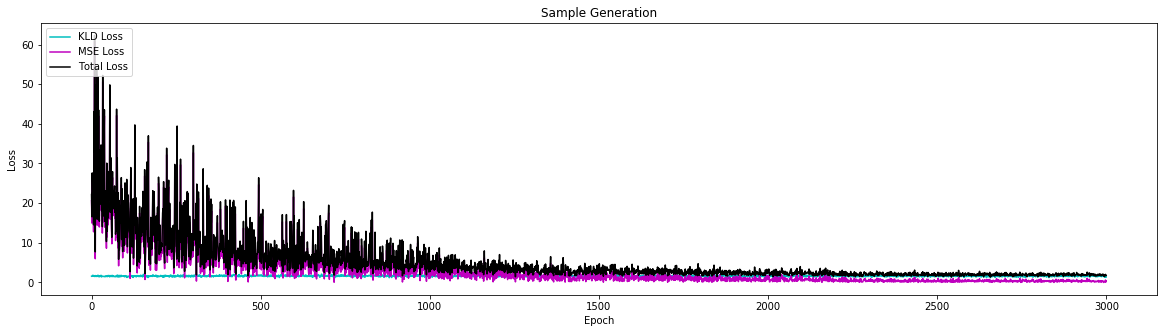

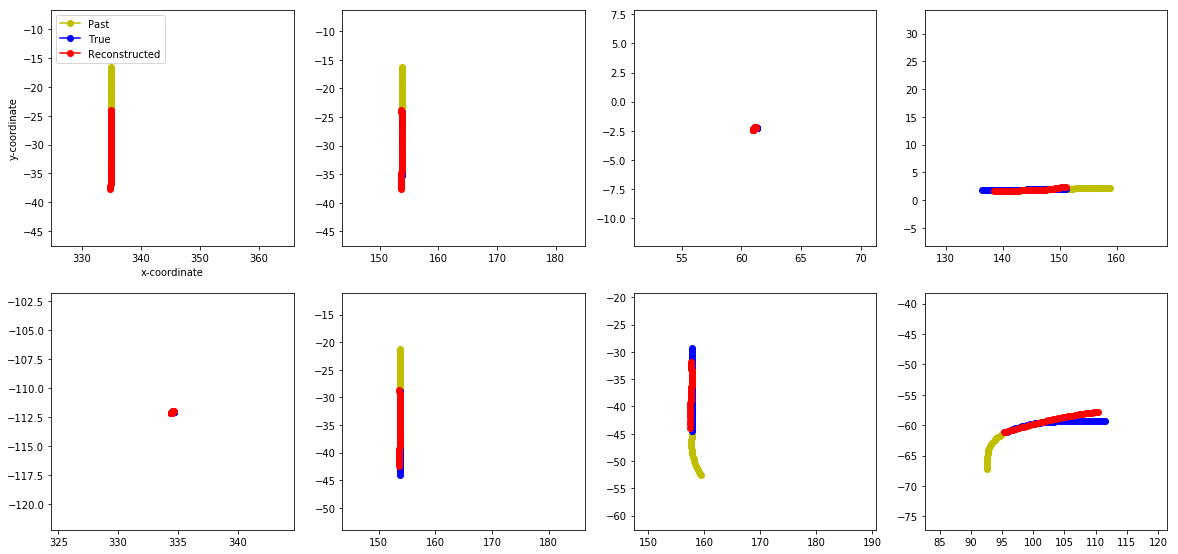

In [12]:
# Hyperparameters
learning_rate = 0.0001
num_epochs = 3000
batch_size = 8
X_seq_len = 20
Y_seq_len = 40

# Initialize model
sg = SampleGenerator(X_seq_len, Y_seq_len, flag='train')

# Loss
kld = nn.KLDivLoss()
mse = nn.MSELoss()

all_kld_loss = []
all_mse_loss = []
all_loss = []

# Optimizer
optimizer = optim.Adam(sg.parameters(), lr=learning_rate)

# writer = SummaryWriter()

for epoch in range(num_epochs):
    X_position, Y_position, X_displacement, Y_displacement = get_batch(X_seq_len, Y_seq_len, batch_size)
    
#     writer.add_scalars('data/X', {
#         'x': X.permute(0, 2, 1)[0][0][0],
#         'y': Y.permute(0, 2, 1)[0][0][0]
#     }, epoch)
    
    optimizer.zero_grad()
    
    Y_hat, beta_z = sg([X_position, Y_position, X_displacement, Y_displacement], batch_size=batch_size)
        
    # Minimise loss
    # KLD Loss requires random z in N(0,1)
    test_z = Variable(torch.normal(torch.zeros(batch_size, 48),
                                   torch.ones(batch_size, 48))).cuda()
    test_z = test_z.unsqueeze(0)
    kld_loss = kld(beta_z, test_z)
    
    # MSE Loss requires to add displacement at all steps before
    Y_true = Y_position.permute(2, 0, 1)
    mse_loss = mse(Y_hat, Y_true)
    
    # Combine losses
    loss = kld_loss + mse_loss
    loss.backward()

    optimizer.step()
    
    all_kld_loss.append(kld_loss.item())
    all_mse_loss.append(mse_loss.item())
    all_loss.append(loss.item())
        
#     print('(Epoch %d) Total Loss: %.3f, KLD Loss: %.3f, MSE Loss: %.3f' 
#           % (epoch + 1, all_loss[epoch], all_kld_loss[epoch], all_mse_loss[epoch]))
    
    if epoch + 1 == num_epochs:
#         print('Completed training')
        
        X_true = X_position
        Y_true = Y_true.permute(1, 2, 0)
        Y_hat = Y_hat.permute(1, 2, 0)

#         print()
        
#         print('Generated Y:')
#         print(Y_hat[0])
        
#         print_line_sep()
        
#         print('True Y:')
#         print(Y_true[0])

        # Plot losses
        loss_fig = plt.figure(figsize=(20, 5))
        ax = loss_fig.add_subplot(1, 1, 1)
        ax.plot(range(num_epochs), all_kld_loss, linestyle='-', color='c', label='KLD Loss')
        ax.plot(range(num_epochs), all_mse_loss, linestyle='-', color='m', label='MSE Loss')
        ax.plot(range(num_epochs), all_loss, linestyle='-', color='k', label='Total Loss')
        ax.set_title('Sample Generation')
        ax.legend(loc='upper left')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

        # Plot all trajectories of the batch
        traj_fig = plt.figure(figsize=(20, 20))
        traj_fig.tight_layout()        
        for i in range(batch_size):
            ax = traj_fig.add_subplot(batch_size/2, batch_size - batch_size/2, i + 1)
         
            ax.plot(X_true[i][0].cpu().detach().numpy(),
                    X_true[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='y', label='Past')
        
            ax.plot(Y_true[i][0].cpu().detach().numpy(),
                    Y_true[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='b', label='True')
        
            ax.plot(Y_hat[i][0].cpu().detach().numpy(),
                    Y_hat[i][1].cpu().detach().numpy(),
                    linestyle='-', marker='o', color='r', label='Reconstructed')
            
            if i == 0:
                ax.legend(loc='upper left')
                ax.set_xlabel('x-coordinate')
                ax.set_ylabel('y-coordinate')

            X_true_x_min = X_true[i][0].cpu().detach().numpy().min()
            X_true_x_max = X_true[i][0].cpu().detach().numpy().max()
            X_true_y_min = X_true[i][1].cpu().detach().numpy().min()
            X_true_y_max = X_true[i][1].cpu().detach().numpy().max()
            
            Y_true_x_min = Y_true[i][0].cpu().detach().numpy().min()
            Y_true_x_max = Y_true[i][0].cpu().detach().numpy().max()
            Y_true_y_min = Y_true[i][1].cpu().detach().numpy().min()
            Y_true_y_max = Y_true[i][1].cpu().detach().numpy().max()

            Y_hat_x_min = Y_hat[i][0].cpu().detach().numpy().min()
            Y_hat_x_max = Y_hat[i][0].cpu().detach().numpy().max()
            Y_hat_y_min = Y_hat[i][1].cpu().detach().numpy().min()
            Y_hat_y_max = Y_hat[i][1].cpu().detach().numpy().min()

            xy_x_min = np.sort(np.array([X_true_x_min, Y_true_x_min, Y_hat_x_min]), axis=None)[0]
            xy_x_max = np.sort(np.array([X_true_x_max, Y_true_x_max, Y_hat_x_max]), axis=None)[-1]
            xy_y_min = np.sort(np.array([X_true_y_min, Y_true_y_min, Y_hat_y_min]), axis=None)[0]
            xy_y_max = np.sort(np.array([X_true_y_max, Y_true_y_max, Y_hat_y_max]), axis=None)[-1]
            
            xy_delta = xy_x_max - xy_x_min if xy_x_max - xy_x_min > xy_y_max - xy_y_min else xy_y_max - xy_y_min
            
            ax.set_xlim(xy_x_min - 10, xy_x_min + xy_delta + 10)
            ax.set_ylim(xy_y_min - 10, xy_y_min + xy_delta + 10)
        
# writer.export_scalars_to_json("./all_scalars.json")
# writer.close()

# Ranking & Refinement Module